---
# Tutorial Objectives

 In this tutorial, we will learn how to infer a latent model when our states are continuous. Particular attention is paid to the Kalman filter and it's mathematical foundation.

In this tutorial, you will:
* Review linear dynamical systems
* Learn about and implement the Kalman filter



In [ ]:
# Install PyKalman (https://pykalman.github.io/)
!pip install pykalman --quiet
!pip install matplotlib --upgrade

# Imports
import numpy as np
import matplotlib.pyplot as plt
import pykalman
from scipy import stats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 36.4 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [ ]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

In [ ]:
#@title Helper functions
np.set_printoptions(precision=3)


def plot_kalman(state, observation, estimate=None, label='filter', color='r-',
                title='LDS', axes=None):
    if axes is None:
      fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
      ax1.plot(state[:, 0], state[:, 1], 'g-', label='true latent')
      ax1.plot(observation[:, 0], observation[:, 1], 'k.', label='data')
    else:
      ax1, ax2 = axes

    if estimate is not None:
      ax1.plot(estimate[:, 0], estimate[:, 1], color=color, label=label)
    ax1.set(title=title, xlabel='X position', ylabel='Y position')
    ax1.legend()

    if estimate is None:
      ax2.plot(state[:, 0], observation[:, 0], '.k', label='dim 1')
      ax2.plot(state[:, 1], observation[:, 1], '.', color='grey', label='dim 2')
      ax2.set(title='correlation', xlabel='latent', ylabel='observed')
    else:
      ax2.plot(state[:, 0], estimate[:, 0], '.', color=color,
               label='latent dim 1')
      ax2.plot(state[:, 1], estimate[:, 1], 'x', color=color,
               label='latent dim 2')
      ax2.set(title='correlation',
              xlabel='real latent',
              ylabel='estimated latent')
    ax2.legend()

    return ax1, ax2


def plot_kf_state(kf, data, ax):
    mu_0 = np.ones(kf.n_dim_state)
    mu_0[:data.shape[1]] = data[0]
    kf.initial_state_mean = mu_0

    mu, sigma = kf.smooth(data)
    ax.plot(mu[:, 0], mu[:, 1], 'limegreen', linewidth=3, zorder=1)
    ax.scatter(mu[0, 0], mu[0, 1], c='orange', marker='>', s=200, zorder=2)
    ax.scatter(mu[-1, 0], mu[-1, 1], c='orange', marker='s', s=200, zorder=2)

---
# Section 1: Linear Dynamical System (LDS)

시간에 따라 선형적으로 상태 변수가 변하는 시스템은 다음과 같이 모델링 가능하다.

Latent state variable (잠재 상태 변수): $$s_t = Fs_{t-1}+\zeta_t$$

Measured/observed variable (측정 변수): $$y_t = Hs_{t}+\eta_t$$

Both latent and measured variable have Gaussian noise terms:

\begin{eqnarray}
\zeta_t & \sim & N(0, Q) \\
\eta_t & \sim & N(0, R) \\
s_0 & \sim & N(\mu_0, \Sigma_0)
\end{eqnarray}

## Section 1.1: Sampling

The first thing we will investigate is how to generate timecourse samples from a linear dynamical system given its parameters. We will start by defining the following system:

In [ ]:
# task dimensions
n_dim_state = 2 # 상태 변수의 차원이 2라고 가정
n_dim_obs = 2 # 관측 변수의 차원이 2라고 가정

# initialize model parameters
params = {
  'F': 0.5 * np.eye(n_dim_state),  # state transition matrix
  'Q': np.eye(n_dim_obs),  # state noise covariance
  'H': np.eye(n_dim_state),  # observation matrix
  'R': 0.1 * np.eye(n_dim_obs),  # observation noise covariance
  'mu_0': np.zeros(n_dim_state),  # initial state mean
  'sigma_0': 0.1 * np.eye(n_dim_state),  # initial state noise covariance
}

**Note**: We used a parameter dictionary `params` above. As the number of parameters we need to provide to our functions increases, it can be beneficial to condense them into a data structure like this to clean up the number of inputs we pass in. The trade-off is that we have to know what is in our data structure to use those values, rather than looking at the function signature directly.

### Exercise 1: Sampling from a linear dynamical system

In this exercise you will implement the dynamics functions of a linear dynamical system to sample both a latent space trajectory (given parameters set above) and noisy measurements.


sample at t=3  [ 2.105 -0.124]


(<Axes: title={'center': 'sample'}, xlabel='X position', ylabel='Y position'>,
 <Axes: title={'center': 'correlation'}, xlabel='latent', ylabel='observed'>)

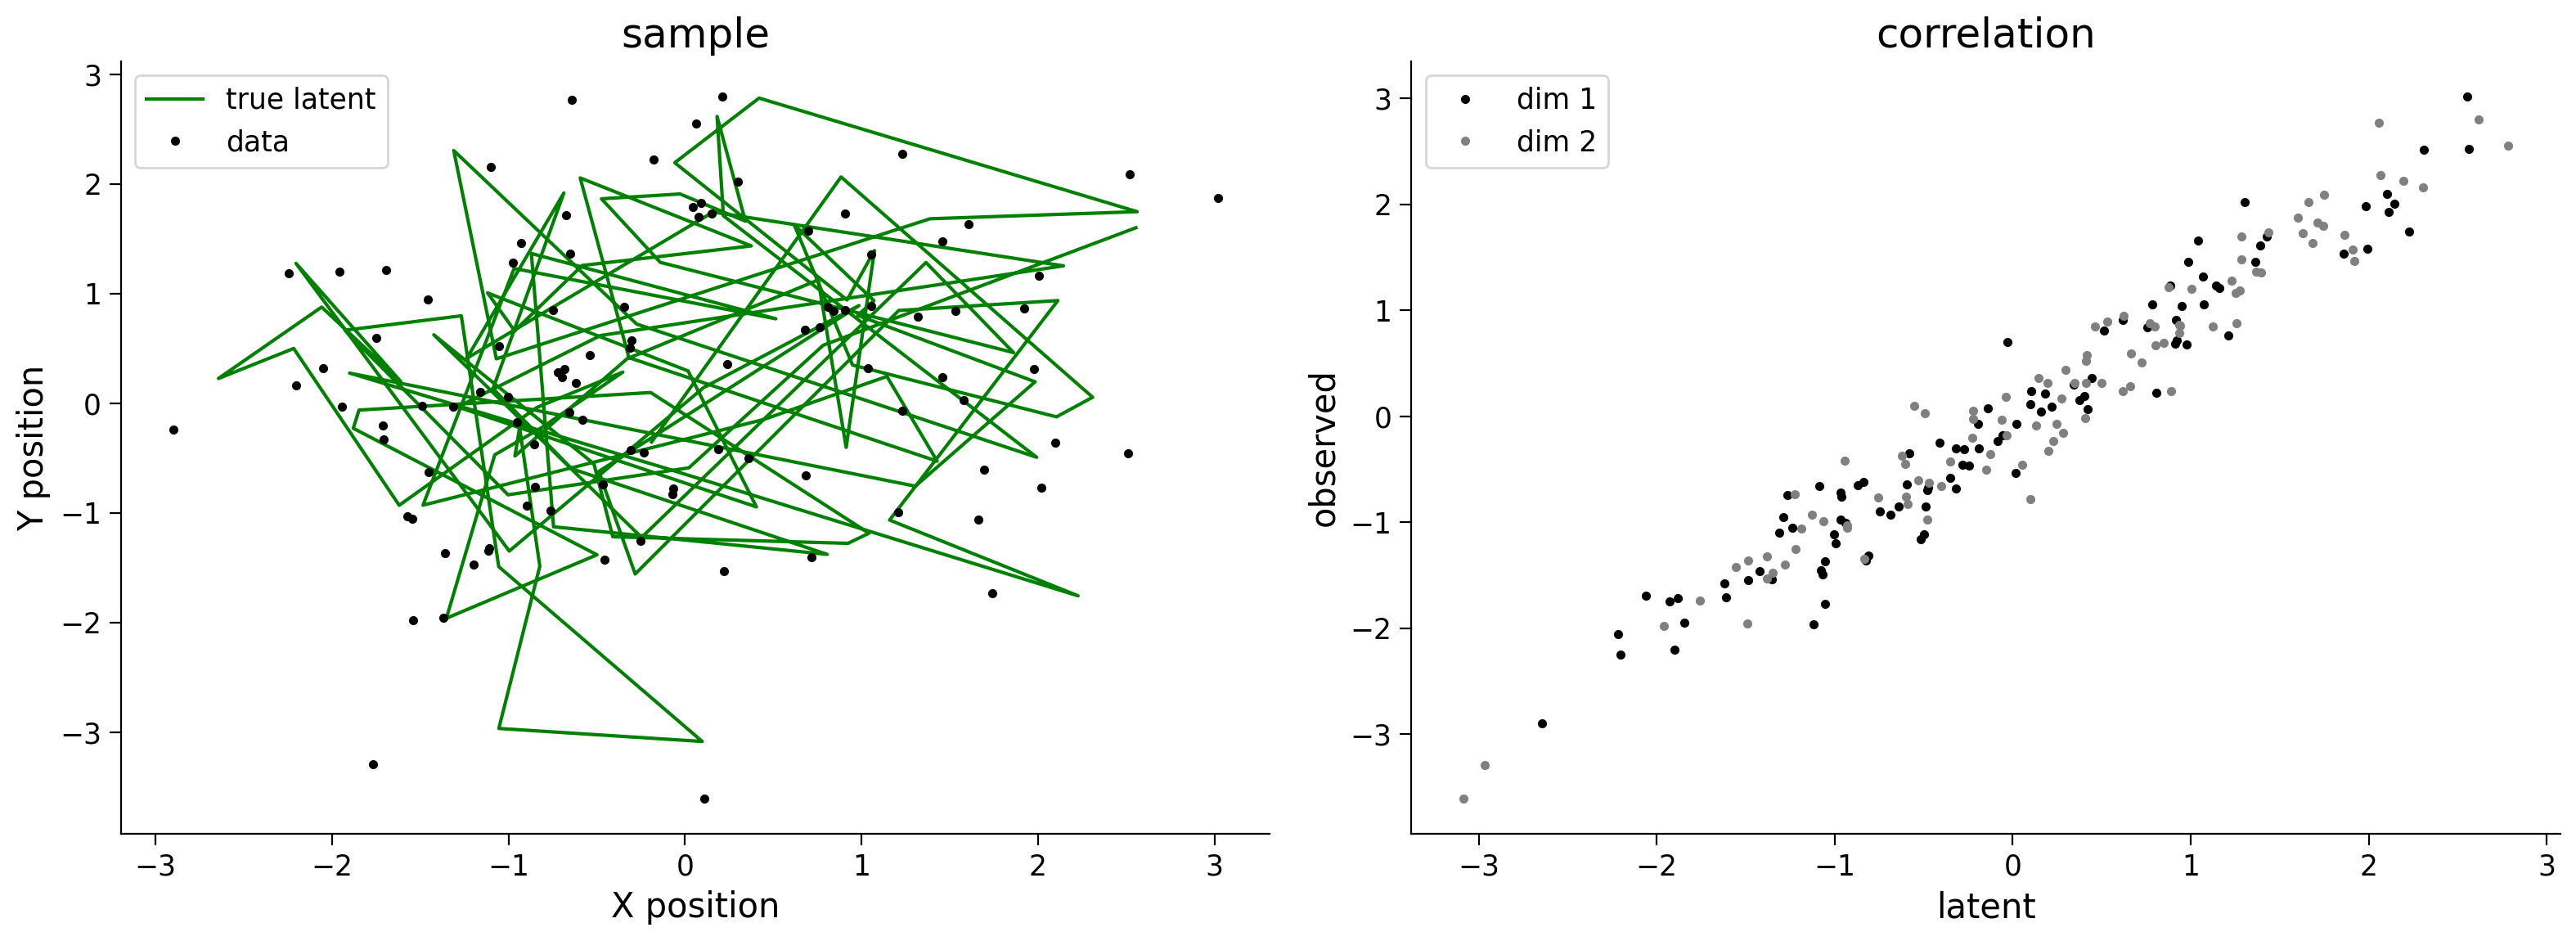

In [ ]:
def sample_lds(n_timesteps, params, seed=0):
  """
  주어진 파라미터에 의해 정의된 선형 동적 시스템(Linear Dynamical System)에서 샘플을 생성하는 함수.

  Args:
  n_timesteps (int): 시뮬레이션할 시간 단계의 수
  params (dict): 모델 파라미터가 포함된 Dictionary (F, Q, H, R, mu_0, sigma_0)
  seed (int): 재현성 검사를 위한 랜덤 시드 값

  Returns:
  ndarray, ndarray: 생성된 상태와 관측 데이터
  """

  # 상태(state) 벡터의 차원 수 정의 (F 행렬의 첫 번째 차원이 상태 벡터의 차원)
  n_dim_state = params['F'].shape[0]

  # 관측(observation) 벡터의 차원 수 정의 (H 행렬의 첫 번째 차원이 관측 벡터의 차원)
  n_dim_obs = params['H'].shape[0]
  np.random.seed(seed)

  # Multivariate Normal Distribution로부터 상태 잡음(zi)와 관측 잡음(eta)을 생성함
  # 상태 잡음 zi는 공분산 행렬 Q에 의해 정의되고, 관측 잡음 eta는 공분산 행렬 R에 의해 정의됨
  zi = stats.multivariate_normal(cov=params['Q']).rvs(n_timesteps)
  eta = stats.multivariate_normal(cov=params['R']).rvs(n_timesteps)

  state = np.zeros((n_timesteps, n_dim_state))
  obs = np.zeros((n_timesteps, n_dim_obs))

  # 시스템을 시뮬레이션함 (시간 t에 따라 상태와 관측치를 계산)
  for t in range(n_timesteps):
    if t == 0:
      # 초기 상태는 주어진 초기 평균(mu_0) 및 초기 공분산(sigma_0)에 따라 설정
      state[t] = stats.multivariate_normal(mean=params['mu_0'],
                                           cov=params['sigma_0']).rvs(1)
    else:
      #### TODO 그 외의 상태는 이전 상태에 전이 행렬 F를 곱하고 상태 noise zi를 더하여 계산 ####
      state[t] = params["F"] @ state[t-1] + zi[t]

    #### TODO 관측 값은 현재 상태에 관측 행렬 H를 곱하고 관측 잡음 eta를 더하여 계산####
    obs[t] = params["H"] @ state[t] + eta[t]

  return state, obs

# 100개의 시간 단계에 대해 파라미터를 이용하여 선형 동적 시스템 샘플을 생성함
state, obs = sample_lds(100, params)

# 시간 단계 3에서의 상태(state)를 출력함
print('sample at t=3 ', state[3])

# 상태와 관측 데이터를 사용하여 칼만 필터의 동작을 시각화함
plot_kalman(state, obs, title='sample')

*Example output:*

<img alt='Solution hint' align='left' width=1133 height=414 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial3_Solution_8cfee88d_1.png>



### Interactive Demo: Adjusting System Dynamics
To test your understanding of the parameters of a linear dynamical system, think about what you would expect if you made the following changes:
1. Reduce observation noise $R$
2. Increase respective temporal dynamics $F$

Use the interactive widget below to vary the values of $R$ and $F$.

interactive(children=(FloatLogSlider(value=0.1, description='R', max=1.0, min=-3.0), FloatSlider(value=0.5, de…

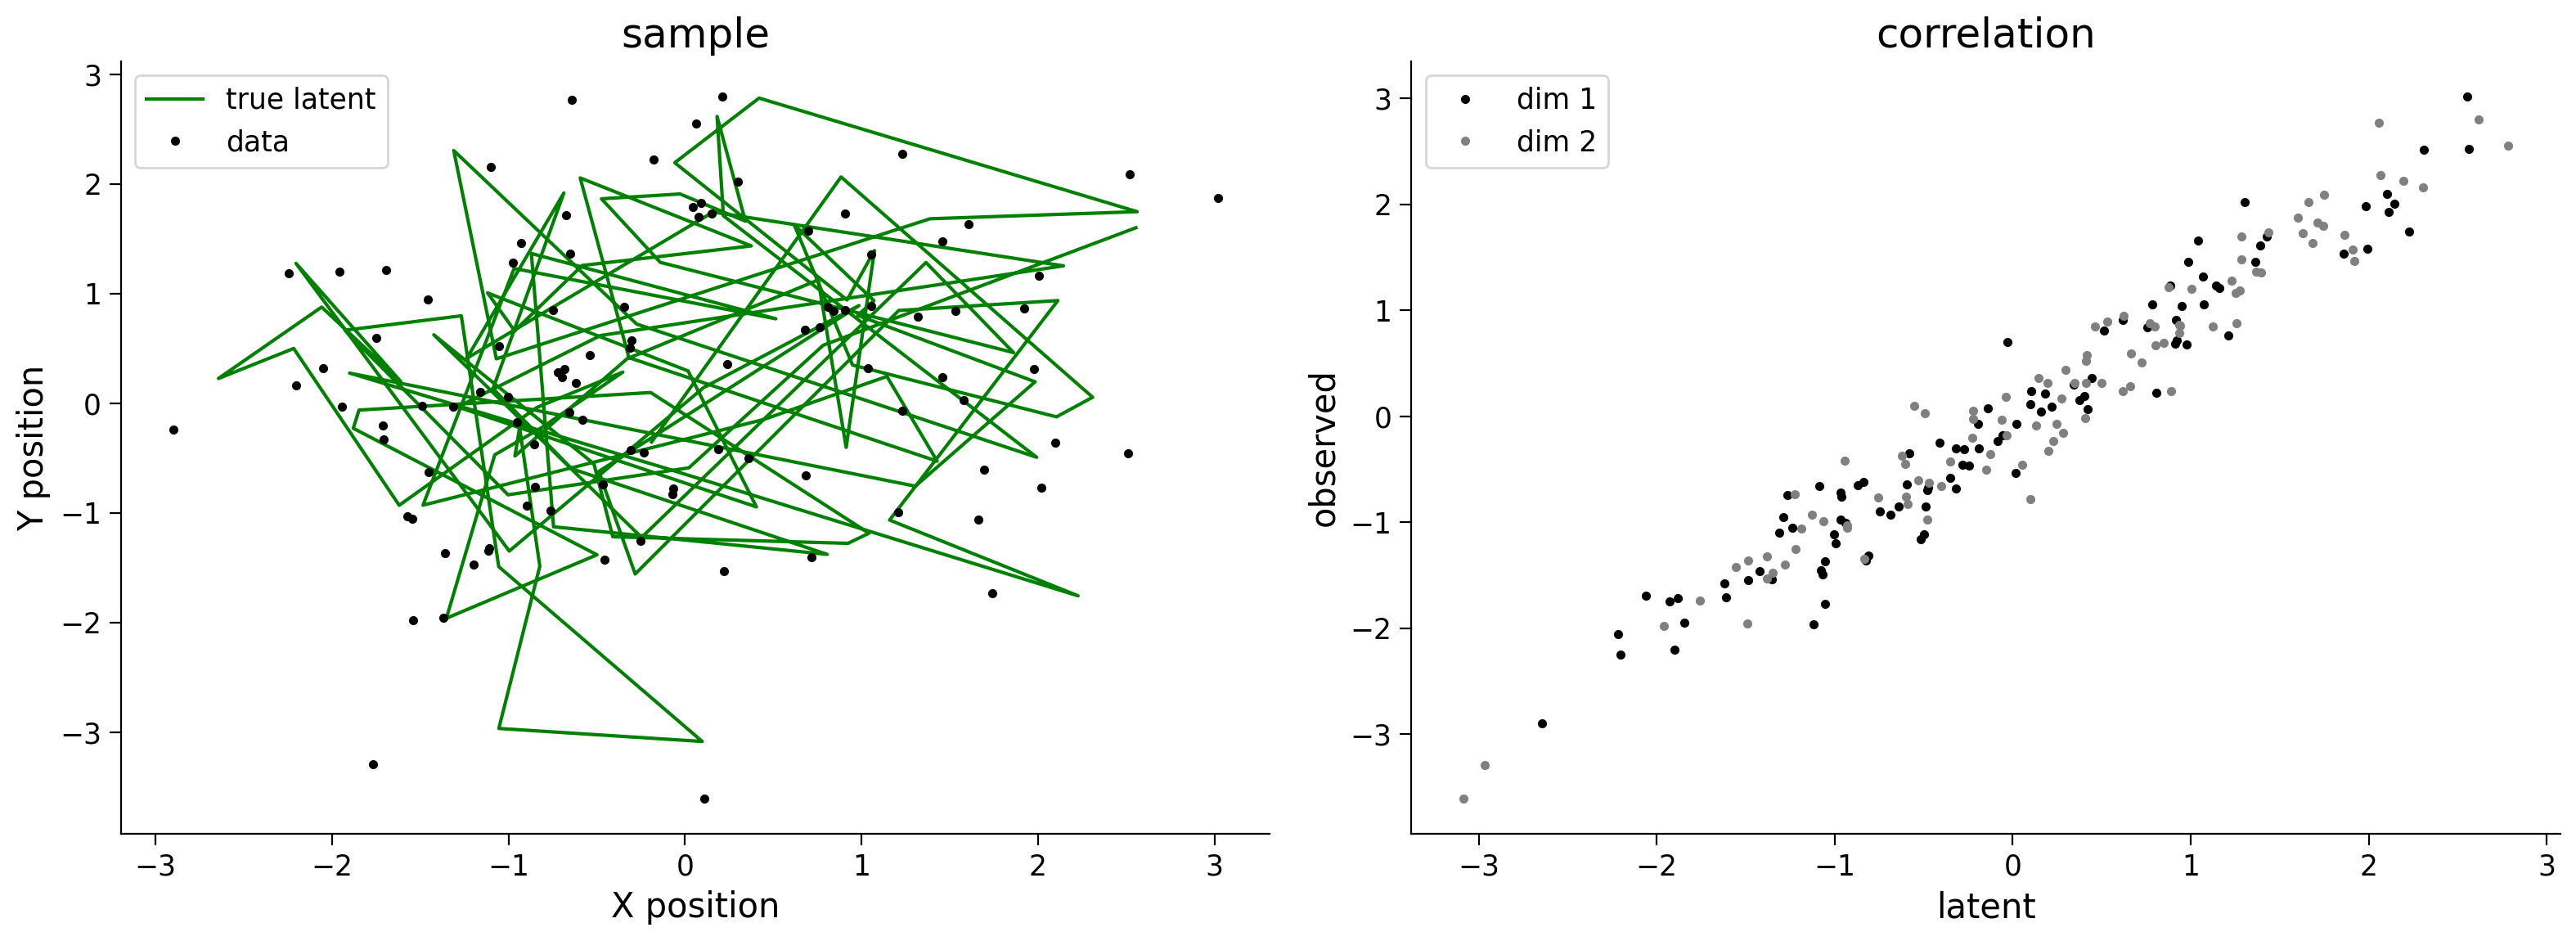

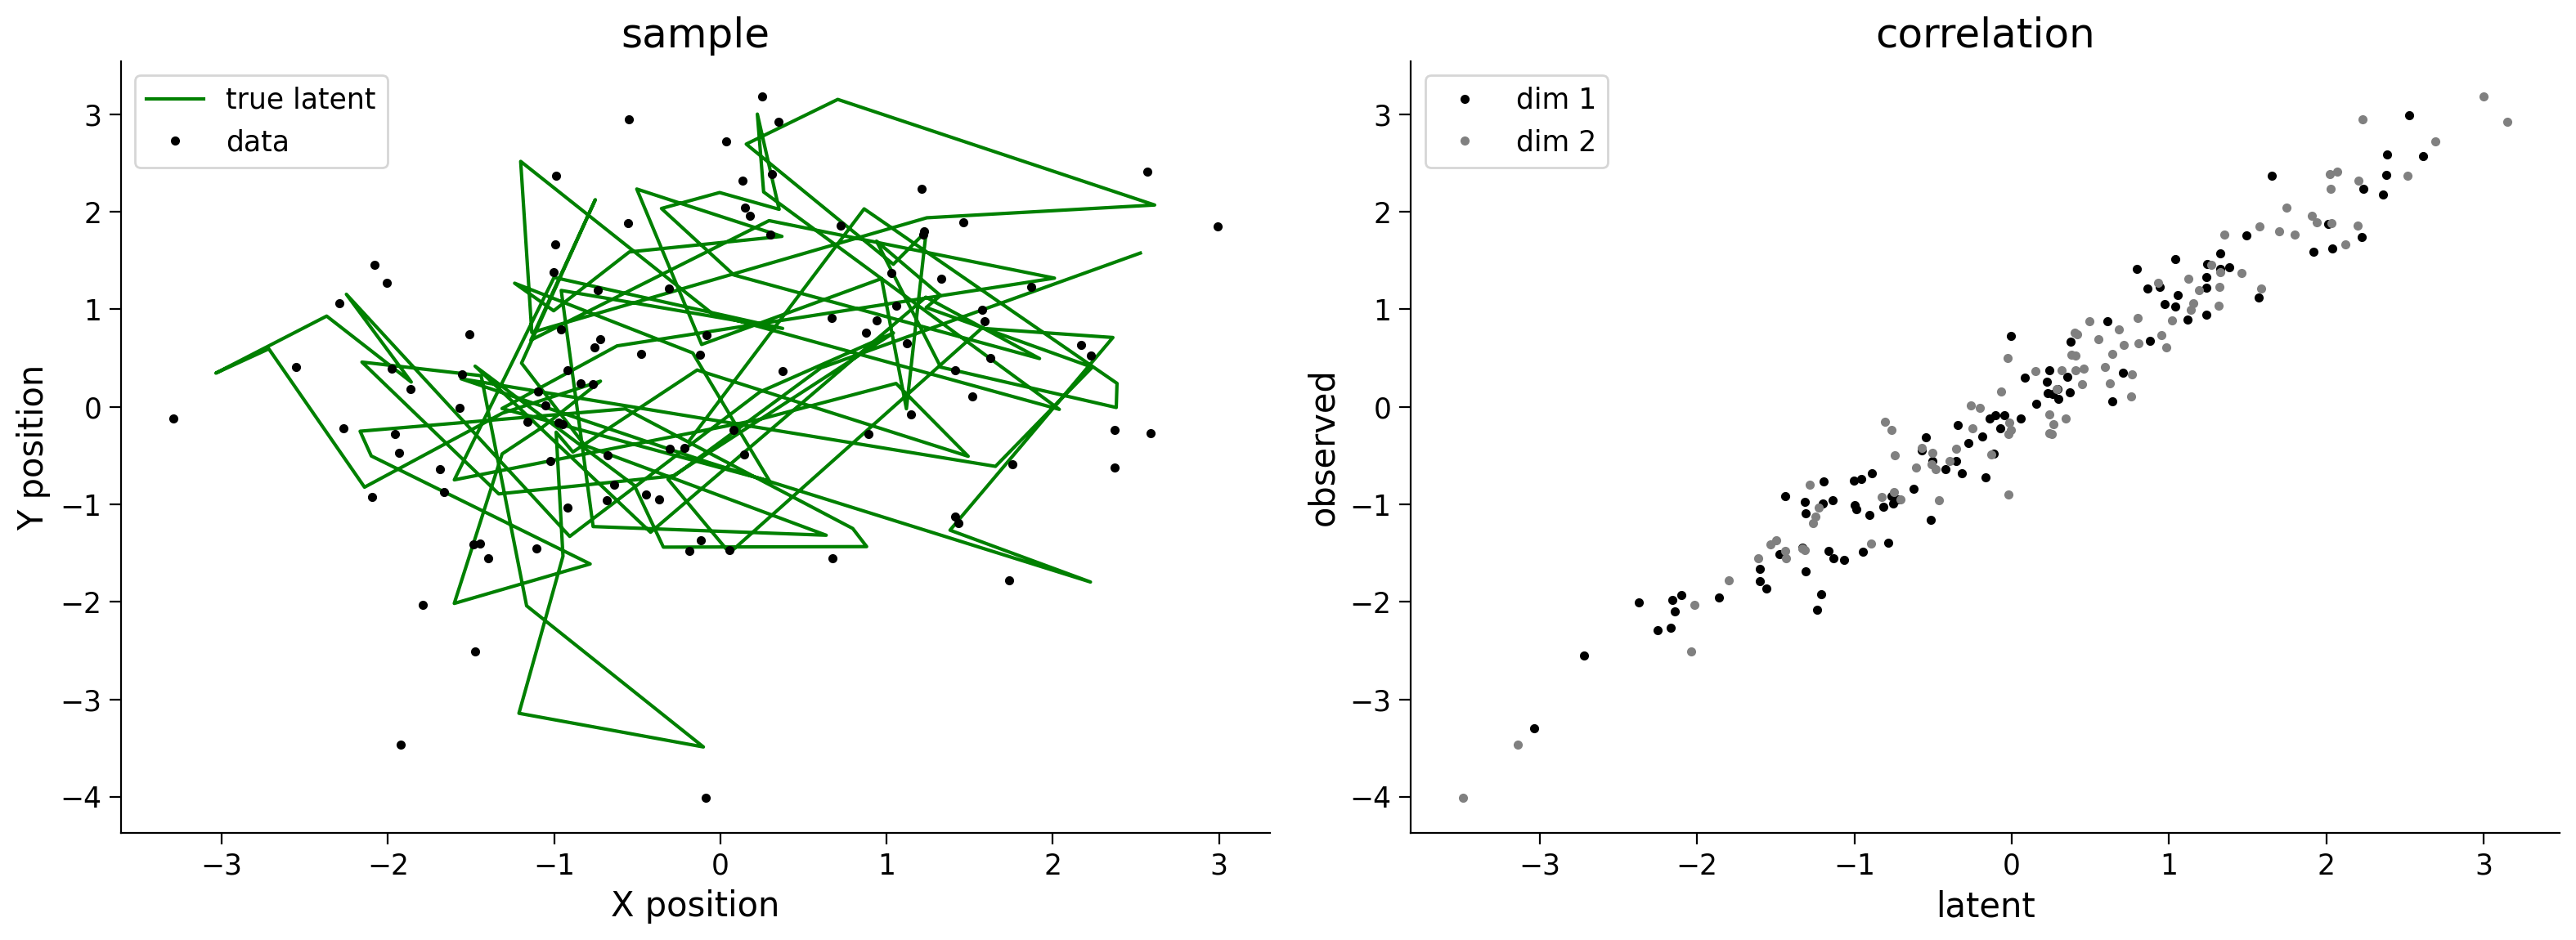

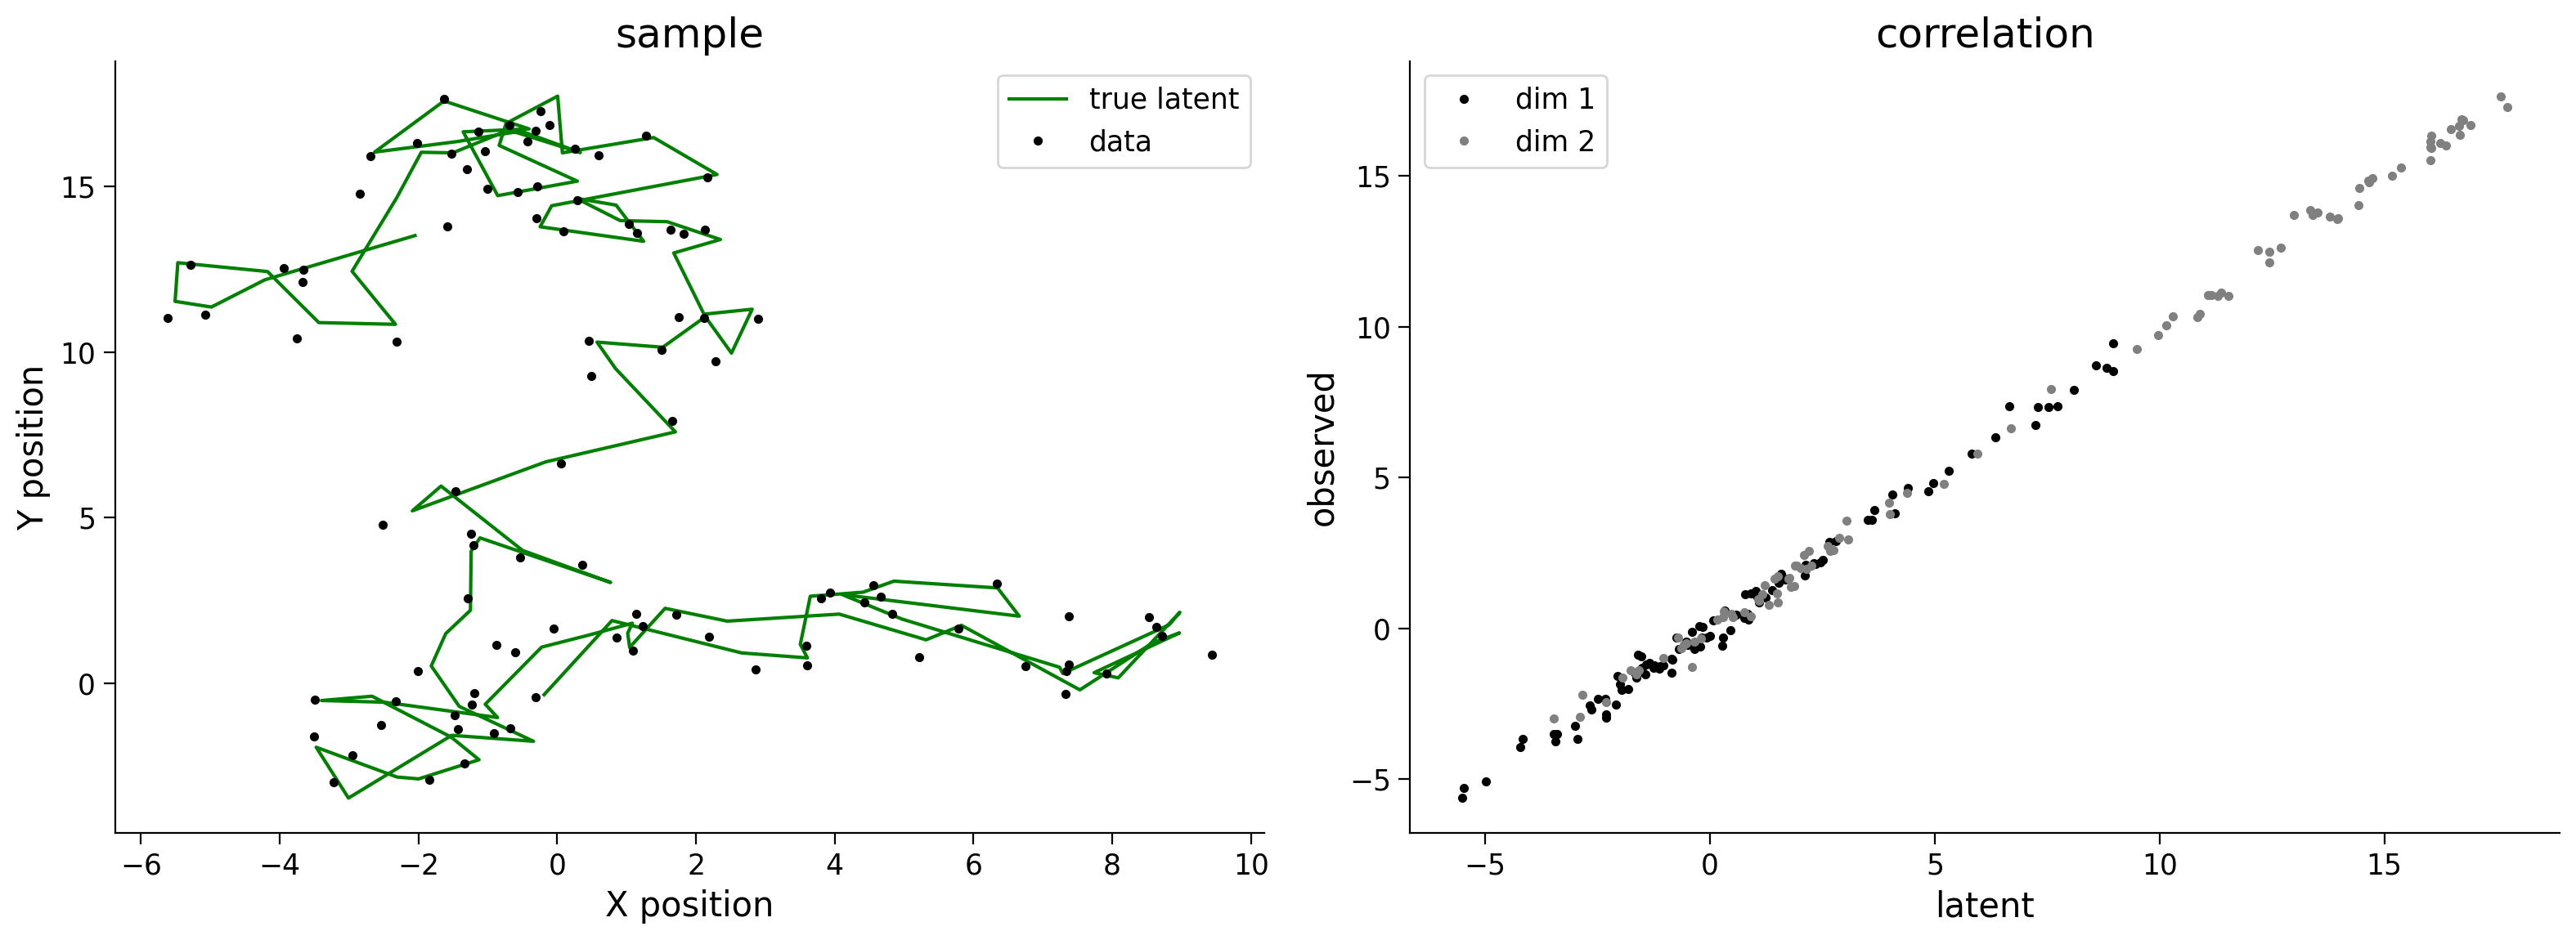

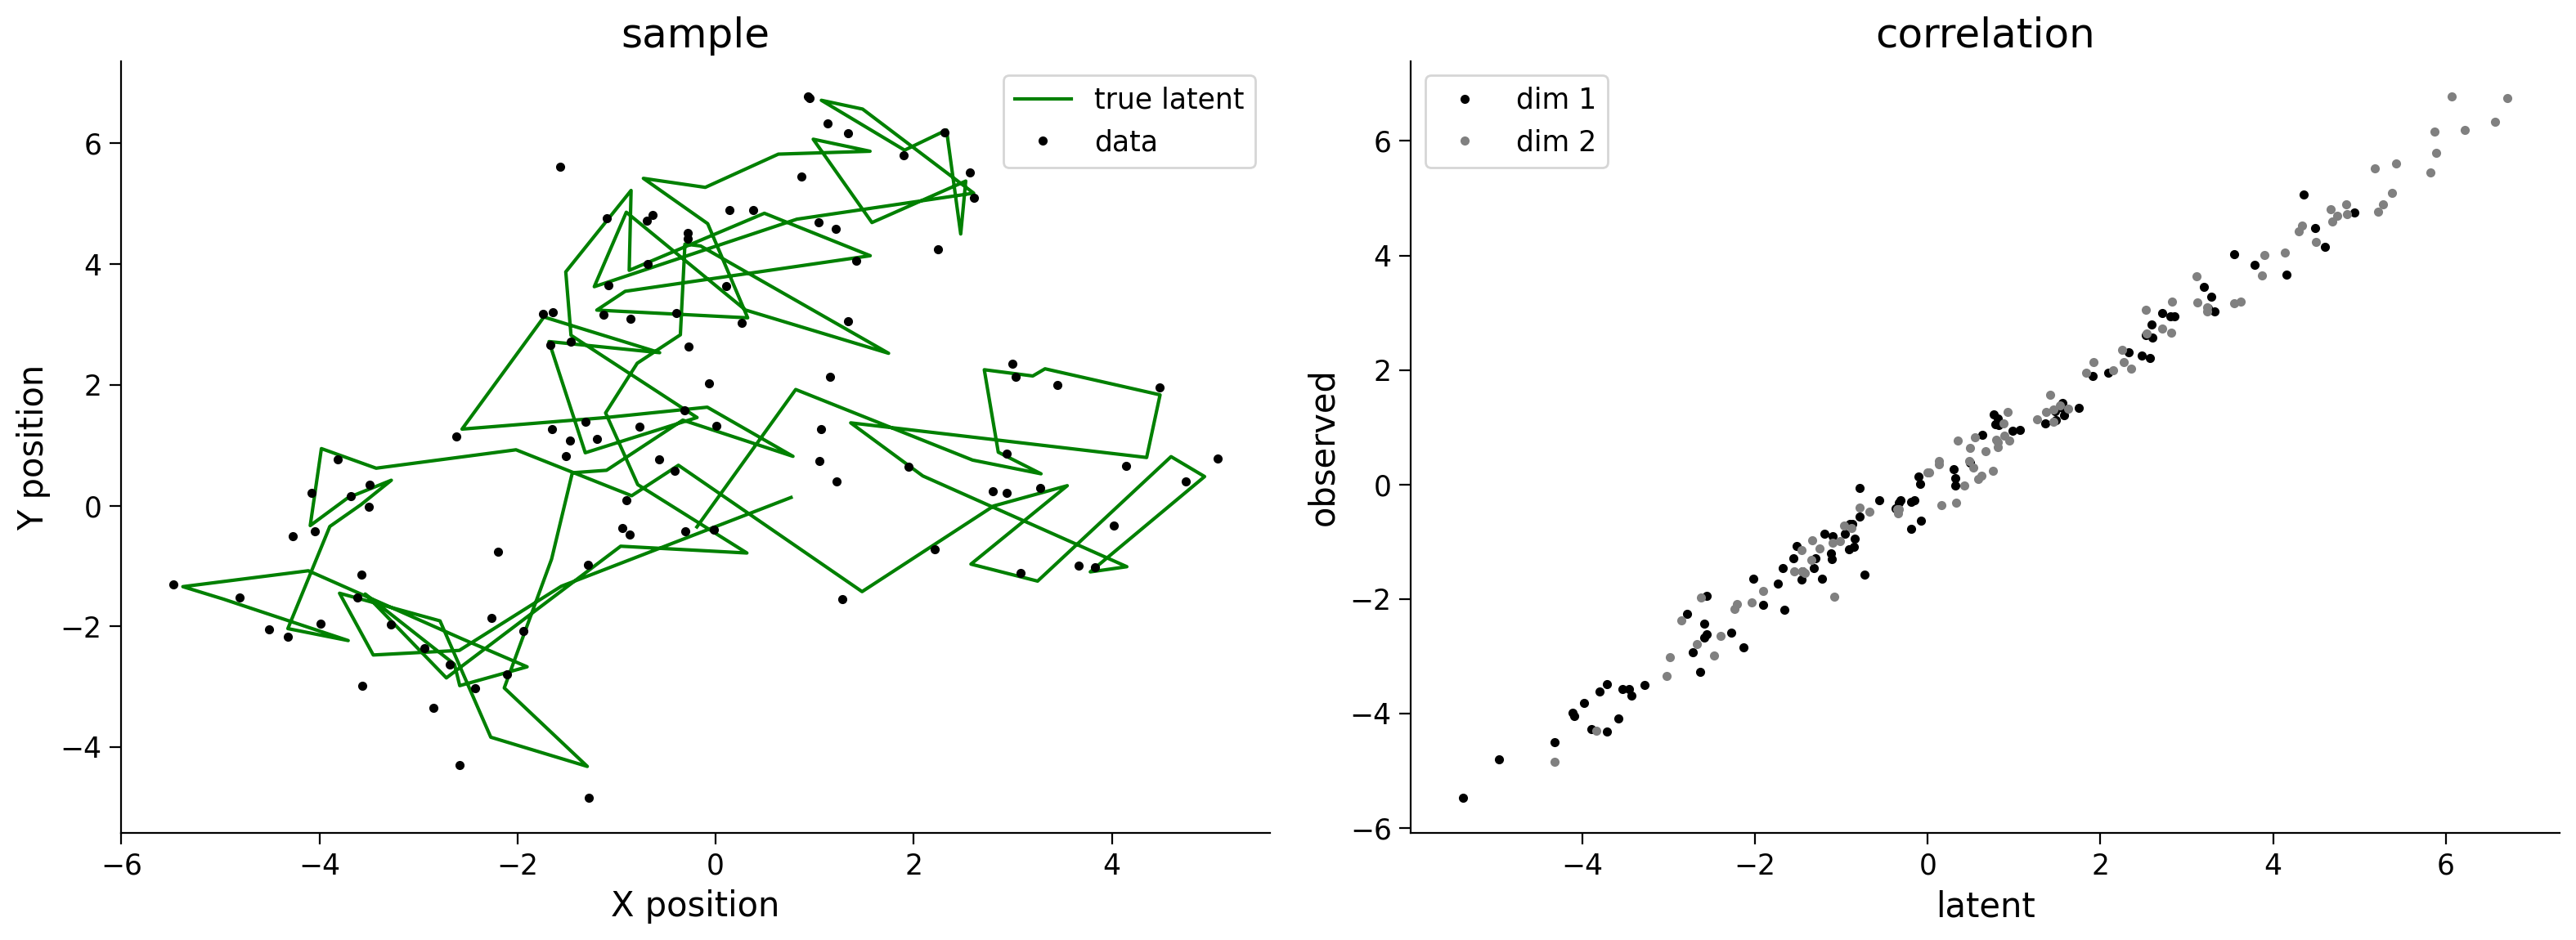

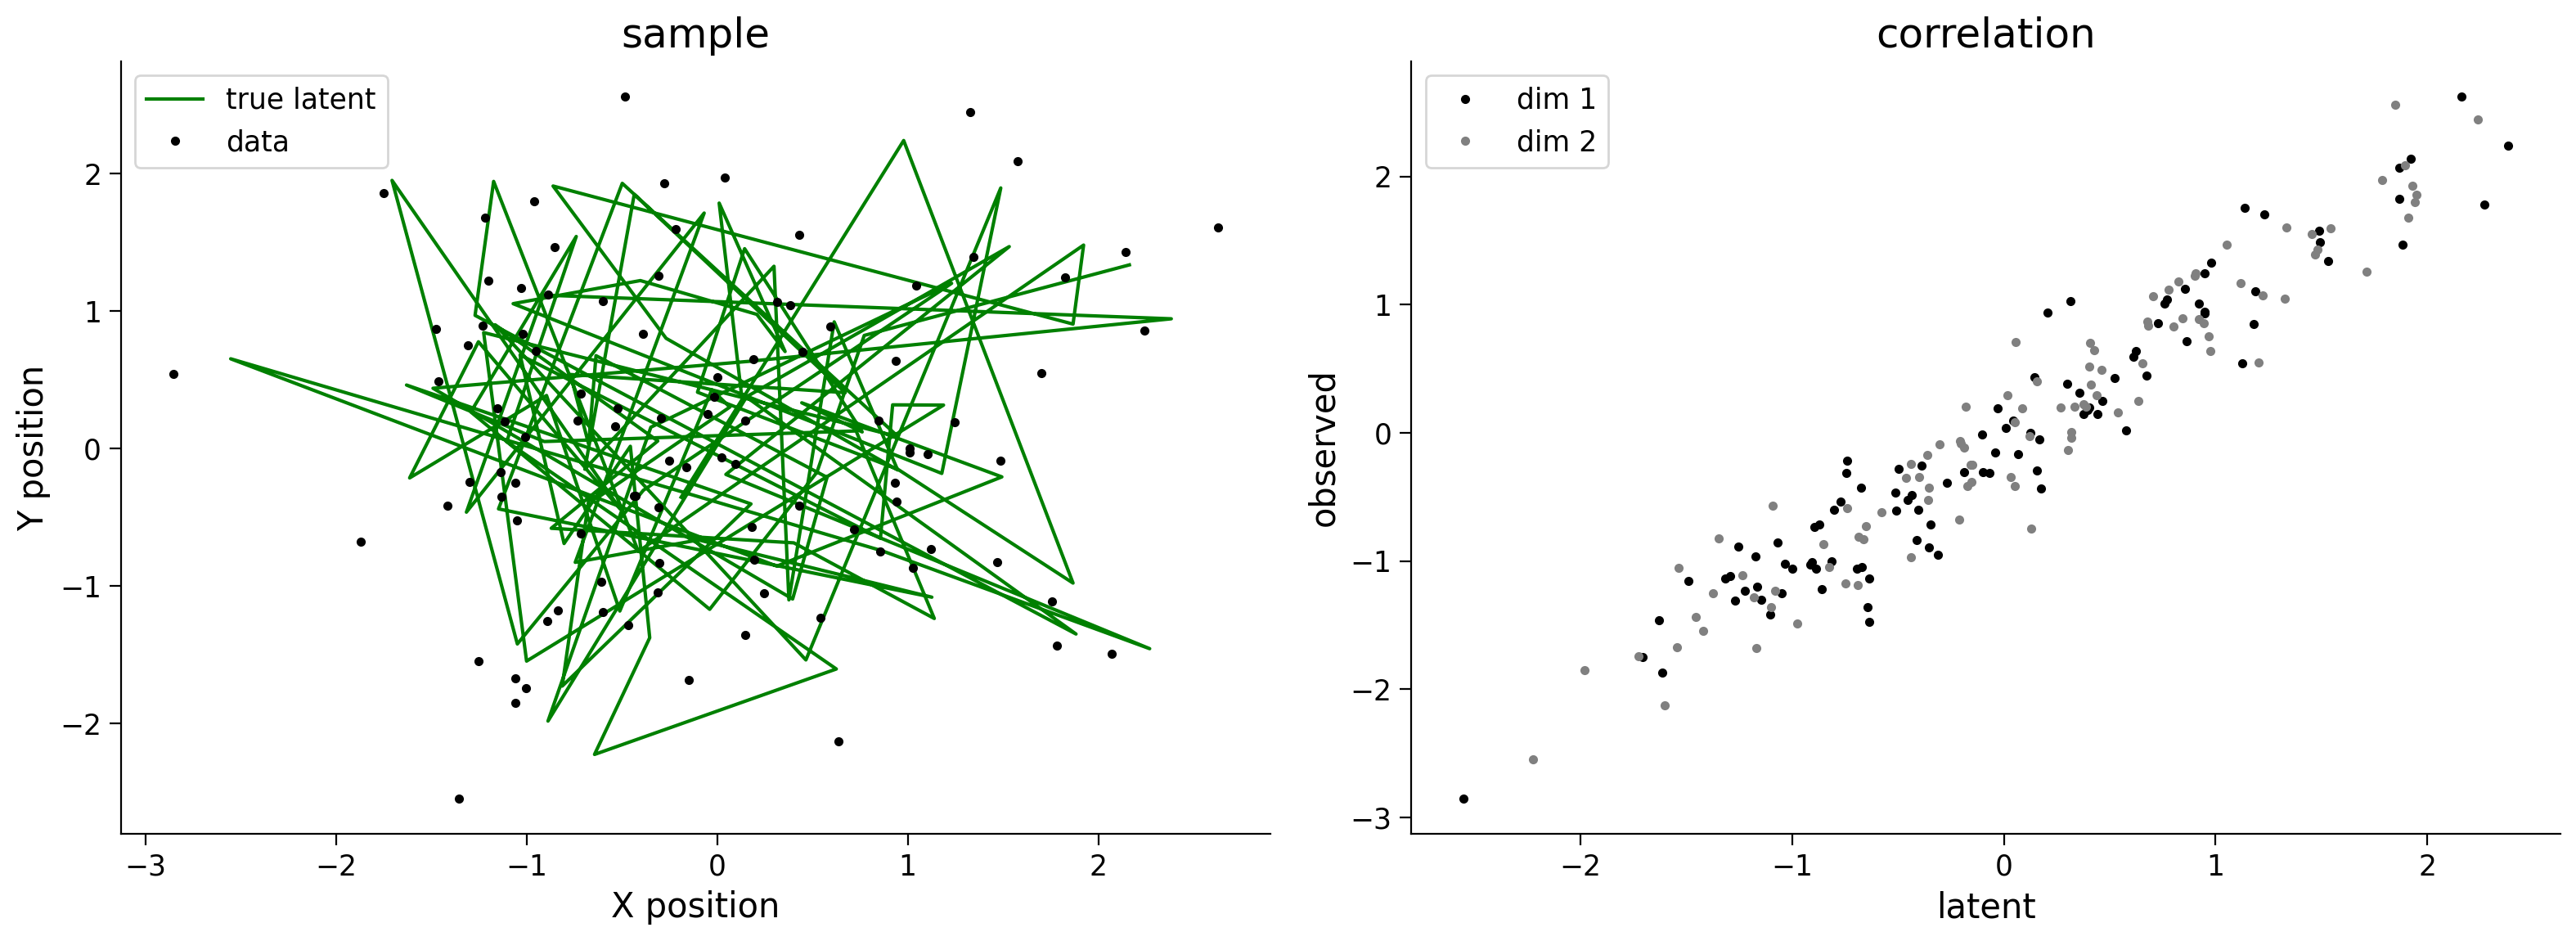

In [ ]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

# R가 작을수록, 즉 관측 잡음이 작을수록 correlation은 1에 가까워집니다.
# F=1일 경우, 상태 벡터는 시간에 따라 변하지 않는 상수로 유지
#(물론 잡음 𝑤𝑡 의 영향으로 미세한 변화가 있을 수 있지만, 평균적으로 동일한 값을 유지하려는 경향이 있습니다).

# F가 커진다는 것은 이전 상태에 대한 현재 상태의 의존성이 증가한다는 것을 의미
# 이는 상태가 시간이 지남에 따라 더 빠르게 변화하거나 커질 수 있다는 것을 나타냅니다.

@widgets.interact(R=widgets.FloatLogSlider(0.1, min=-3, max=1),
                  F=widgets.FloatSlider(0.5, min=0.0, max=1.0))
def explore_dynamics(R=0.1, F=0.5):
    params = {
    'F': F * np.eye(n_dim_state),  # state transition matrix
    'Q': np.eye(n_dim_obs),  # state noise covariance
    'H': np.eye(n_dim_state),  # observation matrix
    'R': R * np.eye(n_dim_obs),  # observation noise covariance
    'mu_0': np.zeros(n_dim_state),  # initial state mean,
    'sigma_0': 0.1 * np.eye(n_dim_state),  # initial state noise covariance
    }

    state, obs = sample_lds(100, params)
    plot_kalman(state, obs, title='sample')

---
# Section 2: Kalman Filtering


We want to **infer the latent state variable $s_t$** given the measured (observed) variable $y_t$.

latent state variable $s_t$: 시스템의 "진짜" 상태를 의미하지만 직접적으로 관측되지 않는 변수

Measured (observed) variable $y_t$: 우리가 실제로 측정하거나 관측할 수 있는 값

$$P(s_t|y_1, ..., y_t, y_{t+1}, ..., y_T)\sim N(\hat{\mu_t}, \hat{\Sigma_t})$$

:평균이 $\hat{\mu_t}$, 공분산이 $\hat{\Sigma_t}$ 인 정규분포




$\hat{\mu_t}$: 관측 데이터를 기반으로 추정된 $s_t$ 의 평균(추정치)

$\hat{\Sigma_t}$:관측 데이터를 기반으로 한 $s_t$의 불확실성(추정치의 분산)

First we obtain estimates of the latent state by running the filtering from $n=0,....N$.

$$s_t^{pred}\sim N(\hat{\mu}_t^{pred},\hat{\Sigma}_t^{pred})$$

Where $\hat{\mu}_t^{pred}$ and $\hat{\Sigma}_t^{pred}$ are derived as follows:

\begin{eqnarray}
\hat{\mu}_1^{pred} & = & F\hat{\mu}_{0} \\
\hat{\mu}_t^{pred} & = & F\hat{\mu}_{t-1}
\end{eqnarray}

*this is the prediction for $s_t$ obtained simply by taking the expected value of $s_{t-1}$ and projecting it forward one step using the transition probability matrix $F$*

\begin{eqnarray}
\hat{\Sigma}_0^{pred} & = & F\hat{\Sigma}_{0}F^T+Q \\
\hat{\Sigma}_t^{pred} & = & F\hat{\Sigma}_{t-1}F^T+Q
\end{eqnarray}

*same for the covariance taking into account the noise covariance $Q$*

update from observation to obtain $\hat{\mu}_t^{filter}$ and $\hat{\Sigma}_t^{filter}$

project to observational space:
$$y_t^{pred}\sim N(H\hat{\mu}_t^{pred}, H\hat{\Sigma}_t^{pred}H^T+R)$$

update prediction by actual data:

\begin{eqnarray}
s_t^{filter} & \sim & N(\hat{\mu}_t^{filter}, \hat{\Sigma}_t^{filter}) \\
\hat{\mu}_t^{filter} & = & \hat{\mu}_t^{pred}+K_t(y_t-H\hat{\mu}_t^{pred}) \\
\hat{\Sigma}_t^{filter} & = & (I-K_tH)\hat{\Sigma}_t^{pred}
\end{eqnarray}

**Kalman gain matrix**:
$$K_t=\hat{\Sigma}_t^{pred}H^T(H\hat{\Sigma}_t^{pred}H^T+R)^{-1}$$

*we use the latent-only prediction to project it to the observational space and compute a correction proportional to the error between prediction and data, coefficient of this correction is the Kalman gain matrix*

*if measurement noise is small and dynamics are fast -> estimation will depend mostly on observed data*

In order to explore the impact of filtering, we will use the following noisy periodic system:

(<Axes: title={'center': 'sample'}, xlabel='X position', ylabel='Y position'>,
 <Axes: title={'center': 'correlation'}, xlabel='latent', ylabel='observed'>)

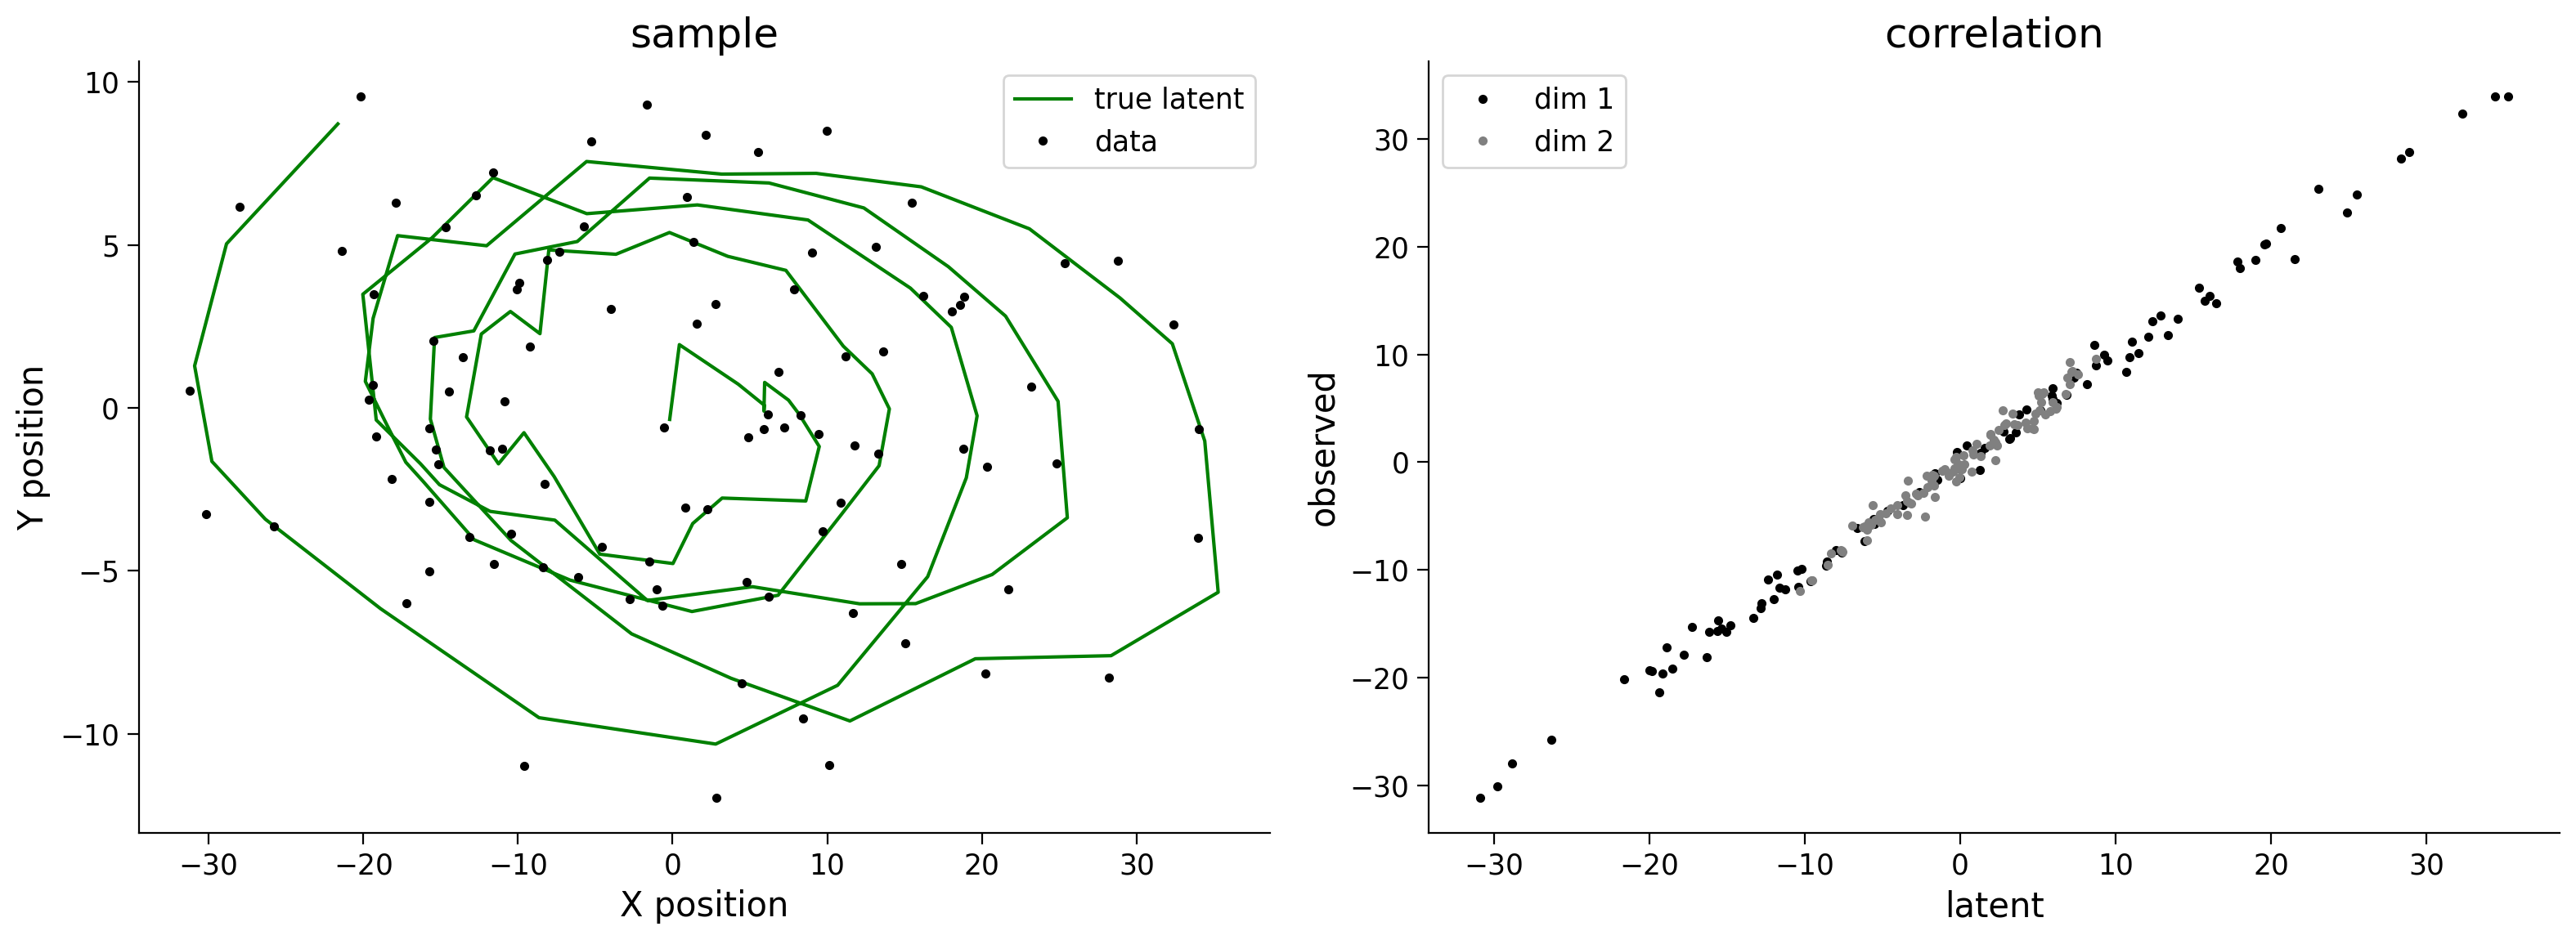

In [ ]:
# task dimensions
n_dim_state = 2
n_dim_obs = 2

# initialize model parameters
params = {
  'F': np.array([[1., 1.], [-(2*np.pi/20.)**2., .9]]),  # state transition matrix
  'Q': np.eye(n_dim_obs),  # state noise covariance
  'H': np.eye(n_dim_state),  # observation matrix
  'R': 1.0 * np.eye(n_dim_obs),  # observation noise covariance
  'mu_0': np.zeros(n_dim_state),  # initial state mean
  'sigma_0': 0.1 * np.eye(n_dim_state),  # initial state noise covariance
}

state, obs = sample_lds(100, params)
plot_kalman(state, obs, title='sample')

## Exercise 2: Implement Kalman filtering
In this exercise you will implement the Kalman filter (forward) process. Your focus will be on writing the expressions for the Kalman gain, filter mean, and filter covariance at each time step (refer to the equations above).

(<Axes: title={'center': 'my kf-filter'}, xlabel='X position', ylabel='Y position'>,
 <Axes: title={'center': 'correlation'}, xlabel='real latent', ylabel='estimated latent'>)

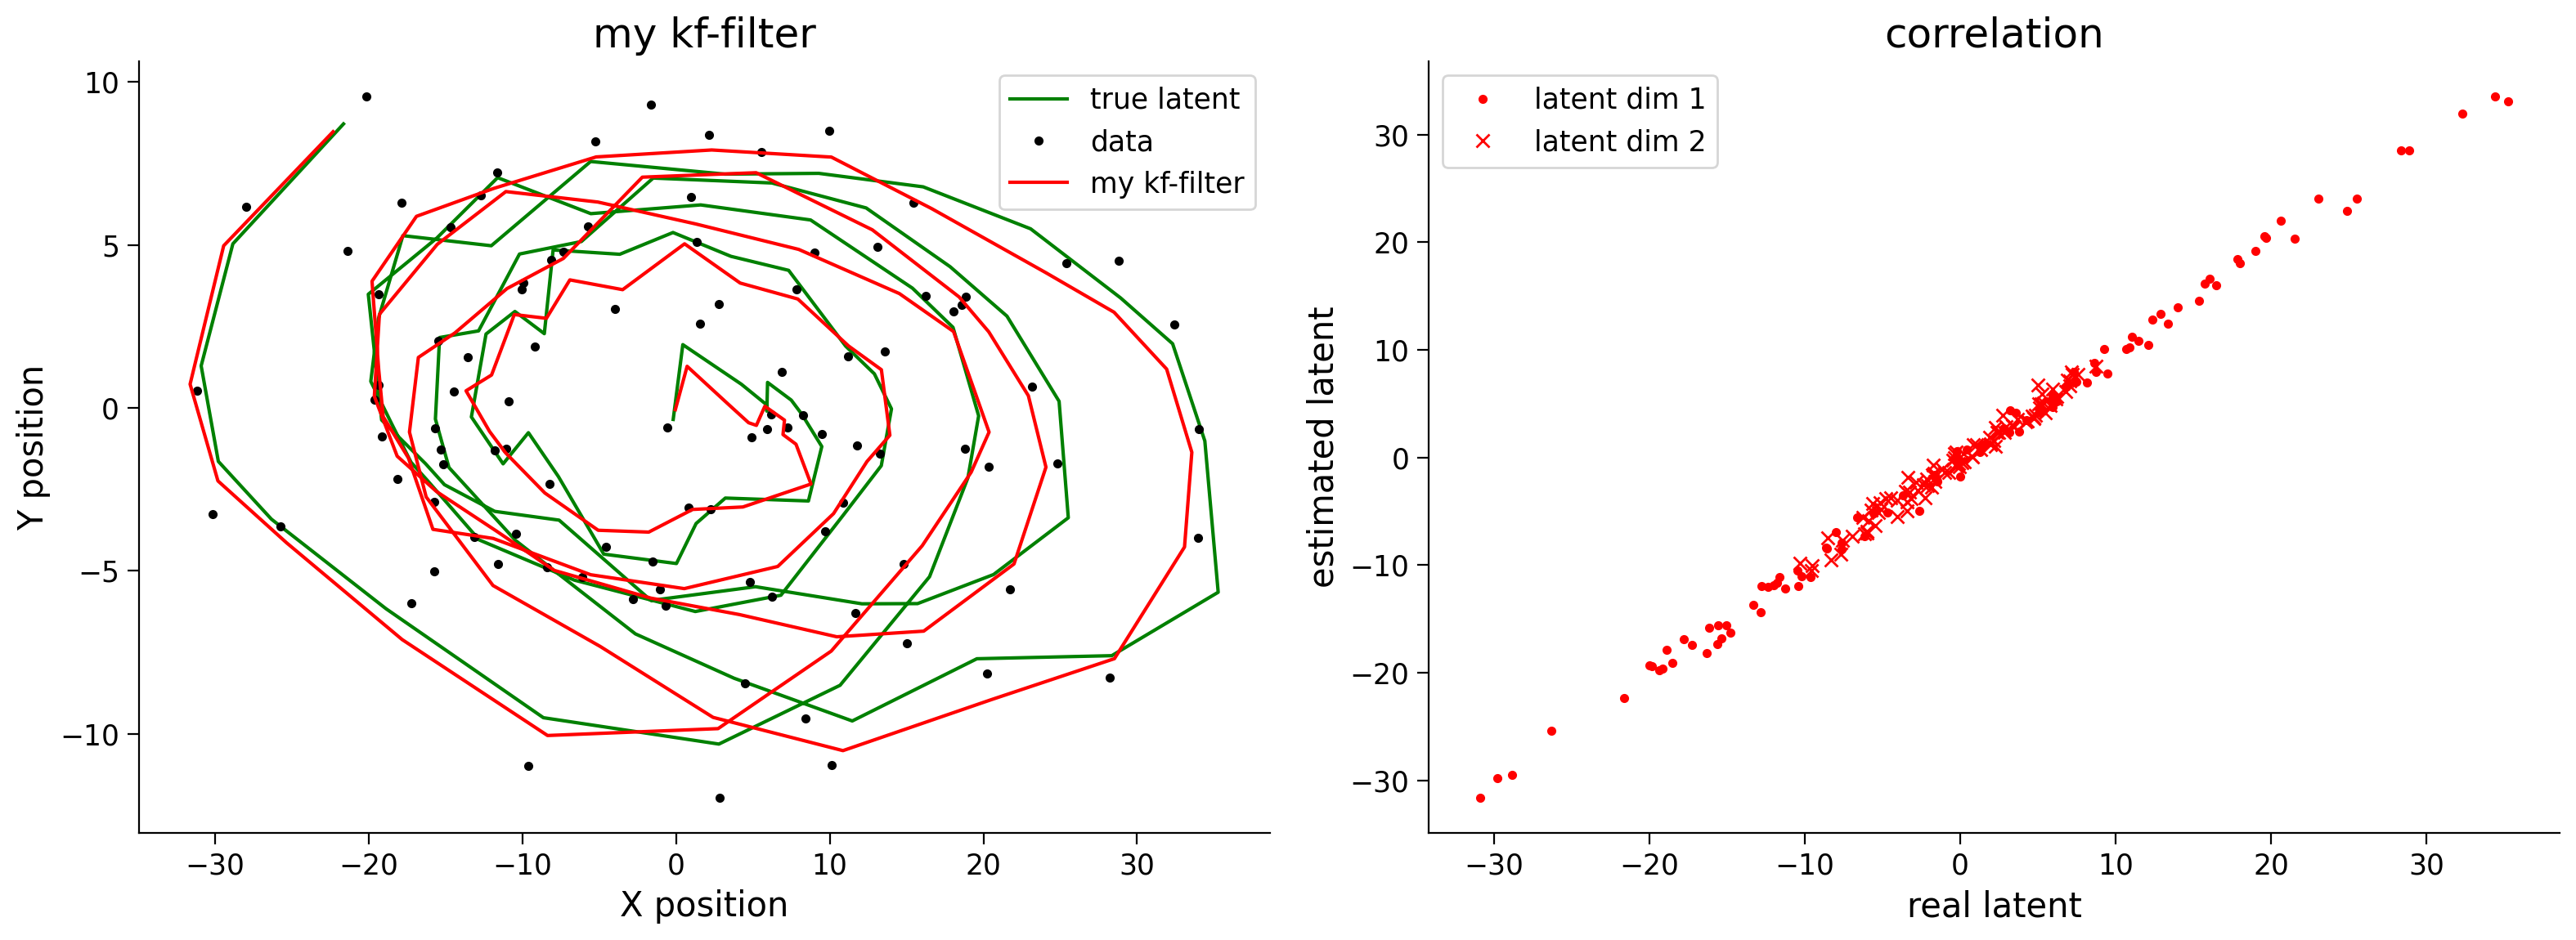

In [12]:
def kalman_filter(data, params):
  """ Perform Kalman filtering (forward pass) on the data given the provided
  system parameters.

  Args:
    data (ndarray): a sequence of osbervations of shape(n_timesteps, n_dim_obs)
    params (dict): a dictionary of model paramters: (F, Q, H, R, mu_0, sigma_0)

  Returns:
    ndarray, ndarray: the filtered system means and noise covariance values
  """
  # pulled out of the params dict for convenience
  F = params['F']
  Q = params['Q']
  H = params['H']
  R = params['R']

  n_dim_state = F.shape[0]
  n_dim_obs = H.shape[0]
  I = np.eye(n_dim_state)  # identity matrix

  # state tracking arrays
  mu = np.zeros((len(data), n_dim_state))
  sigma = np.zeros((len(data), n_dim_state, n_dim_state))

  # filter the data
  for t, y in enumerate(data):
    if t == 0:
      mu_pred = params['mu_0']
      sigma_pred = params['sigma_0']
    else:
      #### TODO prediction of the state and covariance at time t ####
      mu_pred = F @ mu[t-1]
      sigma_pred = F @ sigma[t-1] @ F.T + Q

    #### TODO write the expression for computing the Kalman gain ####
    K = sigma_pred @ H.T @ np.linalg.inv(H @ sigma_pred @ H.T + R)

    #### TODO write the expression for computing the filtered state mean ####
    mu[t] = mu_pred + K @ (y - H @ mu_pred)

    #### TODO write the expression for computing the filtered state noise covariance ####
    sigma[t] = (I - K @ H) @ sigma_pred

  return mu, sigma


filtered_state_means, filtered_state_covariances = kalman_filter(obs, params)

plot_kalman(state, obs, filtered_state_means, title="my kf-filter",
              color='r', label='my kf-filter')

*Example output:*

<img alt='Solution hint' align='left' width=1133 height=414 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial3_Solution_e9df5afe_0.png>



# Linear Dynamical Systems & The Kalman Filter

**Acknowledgement**

This tutorial is in part based on code originally created by Caroline Haimerl for Dr. Cristina Savin's *Probabilistic Time Series* class at the Center for Data Science, New York University